# Data Visualization with Python
## Coursera Course Dataset Analysis

### Table of Contents
1. [Introduction](#introduction)
2. [Data Import](#data-import)
3. [Data Cleaning](#data-cleaning)
4. [Exploratory Data Analysis (EDA)](#exploratory-data-analysis-eda)

*P.S. Clickable function works in Jupiter notebook environment.*

<a id="introduction"></a>

---

### Introduction

### Data Import
Importing all needed libraries for analysis and visualization. Also, making sure that plots are displayed inline and work with Jupiter notebook format.  

In [22]:
import pandas as pd
import numpy as np
from rapidfuzz import fuzz
import kaleido as kld
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
import seaborn as sns
import plotly.express as px
%matplotlib inline
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
cf.go_offline()
import plotly.io as pio
pio.renderers.default = "vscode+png"


Next, importing data and seeing preview of it. 

In [23]:
df = pd.read_csv("coursea_data.csv", index_col=0)
df.sort_index(inplace=True)
df.head()

,course_title,course_organization,course_Certificate_type,course_rating,course_difficulty,course_students_enrolled
0,IBM Data Science,IBM,PROFESSIONAL CERTIFICATE,4.6,Beginner,480k
1,Introduction to Data Science,IBM,SPECIALIZATION,4.6,Beginner,310k
2,The Science of Well-Being,Yale University,COURSE,4.9,Mixed,2.5m
3,Python for Everybody,University of Michigan,SPECIALIZATION,4.8,Beginner,1.5m
4,Google IT Support,Google,PROFESSIONAL CERTIFICATE,4.8,Beginner,350k


In [24]:
df.shape

(891, 6)

### Data cleaning

#### Data types
First, need to fix incorrect data types. 

In [25]:
df.dtypes

course_title                 object
course_organization          object
course_Certificate_type      object
course_rating               float64
course_difficulty            object
course_students_enrolled     object
dtype: object

String data is set to object type. Will convert it to categorical pandas extension type. It's good practice for performance improvement.  
Also, column "course_students_enrolled" should be numeric but is object type right now due to having "k" and "m" values instead of zeros. Need to make it numeric instead. 

In [26]:
df[["course_title", "course_organization", "course_Certificate_type", "course_difficulty"]] = df[["course_title", "course_organization", "course_Certificate_type", "course_difficulty"]].astype('category')
values = df["course_students_enrolled"].str[-1]
values.unique()

array(['k', 'm'], dtype=object)

In [27]:
df["course_students_enrolled"] = df["course_students_enrolled"].apply(lambda value: int(float(value[:-1])*1000) if value.endswith("k") else int(float(value[:-1])*1000000))

In [28]:
df.head(3)

,course_title,course_organization,course_Certificate_type,course_rating,course_difficulty,course_students_enrolled
0,IBM Data Science,IBM,PROFESSIONAL CERTIFICATE,4.6,Beginner,480000
1,Introduction to Data Science,IBM,SPECIALIZATION,4.6,Beginner,310000
2,The Science of Well-Being,Yale University,COURSE,4.9,Mixed,2500000


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 0 to 890
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   course_title              891 non-null    category
 1   course_organization       891 non-null    category
 2   course_Certificate_type   891 non-null    category
 3   course_rating             891 non-null    float64 
 4   course_difficulty         891 non-null    category
 5   course_students_enrolled  891 non-null    int64   
dtypes: category(4), float64(1), int64(1)
memory usage: 70.9 KB


#### Missing values
From above it's visible that that there are no nulls. Just in case, can check again using this code.

In [30]:
df.isnull().any().any()

np.False_

Seems there are none. 
#### Duplicates
First, need to check general overview of the data. Will need to redo type casting because str functions change output back to object type.

In [31]:
df = df.apply(lambda x: x.str.lower().str.strip() if x.dtype == "category" else x)
df[["course_title", "course_organization", "course_Certificate_type", "course_difficulty"]] = df[["course_title", "course_organization", "course_Certificate_type", "course_difficulty"]].astype('category')
df.describe(include="all")

,course_title,course_organization,course_Certificate_type,course_rating,course_difficulty,course_students_enrolled
count,891,891,891,891.000000,891,8.910000e+02
unique,888,154,3,NaN,4,NaN
top,developing your musicianship,university of pennsylvania,course,NaN,beginner,NaN
freq,2,59,582,NaN,487,NaN
mean,NaN,NaN,NaN,4.677329,NaN,9.055208e+04
std,NaN,NaN,NaN,0.162225,NaN,1.819365e+05
min,NaN,NaN,NaN,3.300000,NaN,1.500000e+03
25%,NaN,NaN,NaN,4.600000,NaN,1.750000e+04
50%,NaN,NaN,NaN,4.700000,NaN,4.200000e+04
75%,NaN,NaN,NaN,4.800000,NaN,9.950000e+04


It's visible, that almost all course titles are unique, but not all. Need to check which and why.

In [32]:
titles = df["course_title"].value_counts()
titles = titles[titles > 1] 
titles = titles.index.tolist()
df[df["course_title"].isin(titles)].sort_values(by="course_title")

,course_title,course_organization,course_Certificate_type,course_rating,course_difficulty,course_students_enrolled
205,developing your musicianship,berklee college of music,specialization,4.8,beginner,54000
756,developing your musicianship,berklee college of music,course,4.8,mixed,41000
6,machine learning,stanford university,course,4.9,mixed,3200000
181,machine learning,university of washington,specialization,4.6,intermediate,290000
241,marketing digital,universidade de são paulo,course,4.8,beginner,81000
325,marketing digital,universidad austral,specialization,4.7,beginner,39000


It's visible that some courses from different organizations have just generic repeatable titles, thus are not duplicates, just called the same way. When it comes to "developing your musicianship" course from "berklee college of music", it's a different case. I went to [Coursera site](https://www.coursera.org/learn/develop-your-musicianship?specialization=musicianship-specialization) to check this data. Turns out this course is part of "Developing Your Musicianship Specialization", thus they course and specialization share the same name. 

Thus, there are no duplicate values.

#### Inconsistent Data Entry

Need to check for inconsistent definitions of values if any are left. For this, checking unique values count.

In [33]:
df["course_difficulty"].value_counts()

course_difficulty
beginner        487
intermediate    198
mixed           187
advanced         19
Name: count, dtype: int64

In [34]:
df["course_Certificate_type"].value_counts()

course_Certificate_type
course                      582
specialization              297
professional certificate     12
Name: count, dtype: int64

All few unique values available are indeed distinct. 
For columns with they more unique values, will need to use fuzz ratio calculation. To start with I picked 90. 

First - "course_title".

In [35]:
course_title_matches = []

course_title_values = df["course_title"].unique()

for first in range(len(course_title_values)):
    for second in range(first+1, len(course_title_values)):
        value1 = course_title_values[first]
        value2 = course_title_values[second]
        similarity_ratio = fuzz.ratio(value1, value2)  

        if similarity_ratio > 90:
            course_title_matches.append({
                'Value 1': value1,
                'Value 2': value2,
                'Similarity': similarity_ratio
            })

course_title_matches = pd.DataFrame(course_title_matches).sort_values(by='Similarity', ascending=False).reset_index(drop=True)
pd.set_option('display.max_colwidth', None)
course_title_matches

,Value 1,Value 2,Similarity
0,excel skills for business: intermediate i,excel skills for business: intermediate ii,98.795181
1,the power of macroeconomics: economic principles in the real world,the power of microeconomics: economic principles in the real world,98.484848
2,"tesol certificate, part 1: teach english now!","tesol certificate, part 2: teach english now!",97.777778
3,developing applications with google cloud platform,developing applications with google cloud platform 日本語版,95.238095
4,introduction to financial accounting,more introduction to financial accounting,93.506494
5,mathematics for machine learning,mathematics for machine learning: pca,92.753623
6,machine learning with tensorflow on google cloud platform,advanced machine learning with tensorflow on google cloud platform,92.682927
7,introduction to web development,introduction to game development,92.063492
8,excel/vba for creative problem solving,"excel/vba for creative problem solving, part 1",90.476190
9,fundamentals of computing,fundamentals of accounting,90.196078


After checking these values, they appear to be similar namings for courses of same specialization. Thus, no inconsistent data entries were found. 

Next - "course_organization".

In [36]:
course_organization_matches = []

course_organization_values = df["course_organization"].unique()

for first in range(len(course_organization_values)):
    for second in range(first+1, len(course_organization_values)):
        value1 = course_organization_values[first]
        value2 = course_organization_values[second]
        similarity_ratio = fuzz.ratio(value1, value2)  

        if similarity_ratio > 90:
            course_organization_matches.append({
                'Value 1': value1,
                'Value 2': value2,
                'Similarity': similarity_ratio
            })

course_organization_matches = pd.DataFrame(course_organization_matches).sort_values(by='Similarity', ascending=False).reset_index(drop=True)
pd.set_option('display.max_colwidth', None)
course_organization_matches

,Value 1,Value 2,Similarity
0,ie business school,iese business school,94.736842
1,essec business school,iese business school,92.682927
2,essec business school,escp business school,92.682927
3,edhec business school,essec business school,90.476190


After checking on Coursera, these are indeed different business schools. Thus, no inconsistent data entries were found. 

Will apply title formatting back for future visualizations. It will change to object type again, so have to recast to category one. 

In [37]:
df = df.apply(lambda x: x.str.title() if x.dtype == "category" else x)
df[["course_title", "course_organization", "course_Certificate_type", "course_difficulty"]] = df[["course_title", "course_organization", "course_Certificate_type", "course_difficulty"]].astype('category')

#### Outliers
Will check what kind of outliers are in numerical columns. To have broader overview, will segment based on certification type and it's difficulty. 
##### Sudents enrolled

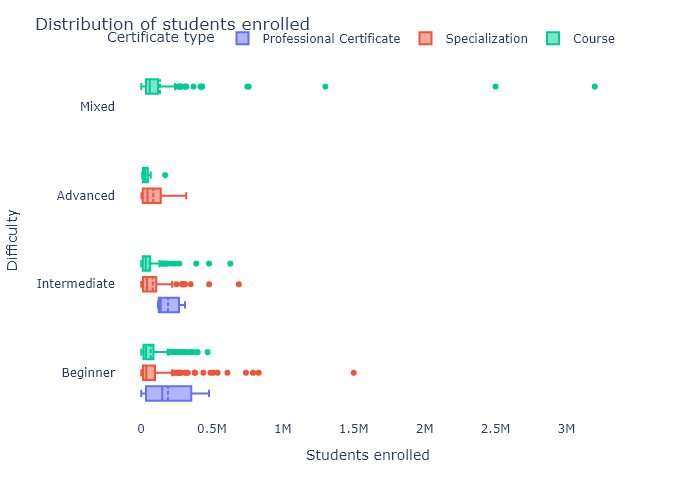

In [38]:
fig = px.box(df, y = "course_difficulty", x="course_students_enrolled", color = "course_Certificate_type", custom_data=["course_title", "course_rating", "course_organization"])
fig.update_layout(
    title = "Distribution of students enrolled",
    xaxis_title = "Students enrolled",
    yaxis_title = "Difficulty",
    legend_title = "Certificate type",
    plot_bgcolor= "white",
    hoverlabel=dict(
        bgcolor="white",
        bordercolor = "white",
        font=dict(
            color="#494a5e"
        )
    ),
    legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
    )
)         
fig.update_traces(
    hovertemplate="Title: <b>%{customdata[0]}</b><br>" +
                  "Students Enrolled: %{x:,.0f}<br>" +
                  "Organization: %{customdata[2]}<br>" +
                  "Rating: %{customdata[1]}<br>",
    boxmean=True
)
  
fig.show()

Can see that certain courses have really high enrolment numbers. To verify this is correct, I looked up their current status on Coursera. For example, ["The Science Of Well-Being"](https://www.coursera.org/learn/the-science-of-well-being#modules) mixed difficulty course has now above 4 million enrollments even. Thus, keeping it and cleanliness of the data so far these values seem to be correct. I will keep them fpr further analysis.

##### Ratings

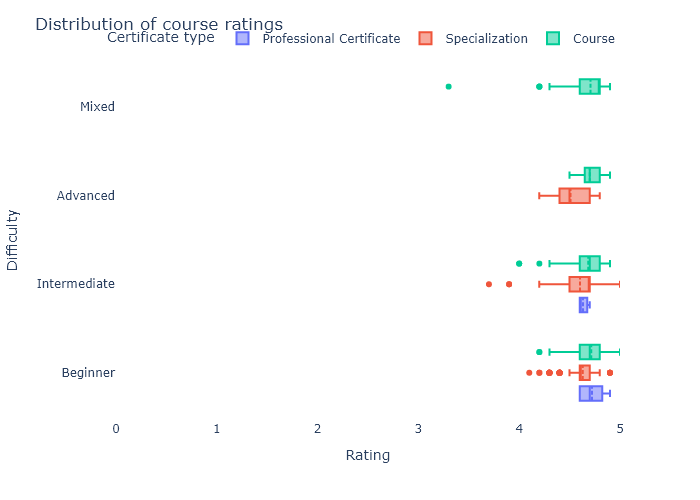

In [40]:
fig = px.box(df, y = "course_difficulty", x="course_rating", color = "course_Certificate_type", custom_data=["course_title", "course_students_enrolled", "course_organization"])
fig.update_layout(
    title = "Distribution of course ratings",
    xaxis=dict(
        title="Rating",
        range=[0, 5] 
    ),
    yaxis_title = "Difficulty",
    legend_title = "Certificate type",
    plot_bgcolor= "white",
    hoverlabel=dict(
        bgcolor="white",
        bordercolor = "white",
        font=dict(
            color="#494a5e"
        )
    ),
    legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
    )
)         
fig.update_traces(
    hovertemplate="Title: <b>%{customdata[0]}</b><br>" + 
                "Students Enrolled: %{customdata[1]:,.0f}<br>" +
                  "Organization: %{customdata[2]}<br>" +
                  "Rating: %{x}<br>",
    boxmean=True
)

fig.show()

Most courses have higher than 4 stars ratings. I checked couple which have way lower ones like ["How To Create A Website In A Weekend! (Project-Centered Course)"](https://www.coursera.org/learn/how-to-create-a-website) and ratings are indeed correct to be this low. Thus, same as before, I will keep them fpr further analysis.

### Exploratory Data Analysis (EDA)